In [114]:
using CSV, Statistics, DataFrames, Plots, FFTW, StatsBase

# Event 
1. Submission of a new limit order
2. Cancellation (partial deletion of a limit order)
3. Deletion (total deletion of a limit order)
4. Execution of a visible limit order
5. Execution of a hidden limit order
6. Indicates a cross trade, e.g. auction trade
7. Trading halt indicator (detailed information below)

In [28]:
INTC_files_message = sort(["../../../Data/INTC/"*i for i in readdir("../../../Data/INTC") if i[end-7]=='e'])
INTC_files_LOB     = sort(["../../../Data/INTC/"*i for i in readdir("../../../Data/INTC") if i[end-7]!='e'])

TSLA_files_message = sort(["../../../Data/TSLA/"*i for i in readdir("../../../Data/TSLA") if i[end-7]=='e'])
TSLA_files_LOB     = sort(["../../../Data/TSLA/"*i for i in readdir("../../../Data/TSLA") if i[end-7]!='e'])
nothing

In [45]:
message  = CSV.read(INTC_files_message[1],DataFrame,header=0)
LOB  = CSV.read(INTC_files_LOB[1],DataFrame,header=0)
LOB

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,367300,4000,365200,400,367500,200,364800,300,367900
2,367300,4000,365200,400,367500,200,364800,300,367900
3,367300,4000,365200,100,367500,200,364800,300,367900
4,367300,4000,365200,100,367500,200,364800,300,367900
5,367300,4000,365200,100,367500,200,364800,300,367900
6,367300,4000,365200,100,367500,200,364800,300,367900
7,367300,4000,365200,100,367500,200,364800,300,367900
8,367300,4000,365200,100,367500,200,364800,300,367900
9,367300,4000,366700,100,367500,200,365200,100,367900


In [57]:
spread = LOB[:,1]-LOB[:,3]
mid = (LOB[:,1]+LOB[:,3])./2
message.Spread = spread
message.MidPrice = mid
rename!(message, ["Time","Event", "OrderID", "OrderVolume","OrderPrice","BuySell","Spread","MidPrice"])
first(message)

,Time,Event,OrderID,OrderVolume,OrderPrice,BuySell,Spread,MidPrice
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,34200.0,5,0,200,367200,1,2100,366250.0


In [70]:
function Window(t, data)
    prev_t = t[1]
    prev_p = data[1]
    n = 1
    result_t = zeros(length(data))
    result_d = zeros(length(data))
    for i in 1:length(data)
        if prev_t != t[i]
            result_t[n] = prev_t
            result_d[n] = prev_p
            n += 1
        end
        prev_p = data[i]
        prev_t = t[i]
    end
    result_t[n] = prev_t
    result_d[n] = prev_p
    return result_t[1:n],result_d[1:n]
end


Window (generic function with 1 method)

In [73]:
t, p = Window(message.Time,message.MidPrice)

([34200.014991269, 34200.015519829, 34200.015920126, 34200.016722494, 34200.018156618, 34200.019282506, 34200.020496833, 34200.022895378, 34200.02362381, 34200.024864374  …  57599.88678837, 57599.914261214, 57599.91456821, 57599.914623109, 57599.953091284, 57599.991741179, 57599.992159765, 57599.992175268, 57599.992177047, 57599.992299271], [366250.0, 366250.0, 366250.0, 366250.0, 366250.0, 366250.0, 366250.0, 367000.0, 367000.0, 367000.0  …  363550.0, 363550.0, 363550.0, 363550.0, 363550.0, 363550.0, 363550.0, 363550.0, 363550.0, 363550.0])

In [83]:

function PriceChangeDecompose(data)
    s = zeros(length(data))
    w = zeros(length(data))
    n = 1 
    prev_p = data[1]
    for i in 1:length(data)
        if prev_p != data[i]
            tmp = prev_p - data[i]
            s[n] = sign(tmp)
            w[n] = abs(tmp)
            n += 1 
        end
        prev_p = data[i]
    end
    return s[1:n-1],w[1:n-1]
end

PriceChangeDecompose (generic function with 1 method)

In [152]:
length(unique(message.Time)),length(message.Time)


(792684, 887629)

In [88]:
s,w = PriceChangeDecompose(p)


([-1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0  …  1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0], [750.0, 50.0, 150.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0])

In [138]:
unique(s)

2-element Vector{Float64}:
 -1.0
  1.0

In [143]:
ECDF = ecdf(w)
x = sort(unique(w))
y = ECDF(x)


10-element Vector{Float64}:
 0.990587243607755
 0.9980331553807249
 0.9990165776903625
 0.9991570665917393
 0.999297555493116
 0.9994380443944928
 0.9995785332958697
 0.9997190221972464
 0.9998595110986233
 1.0

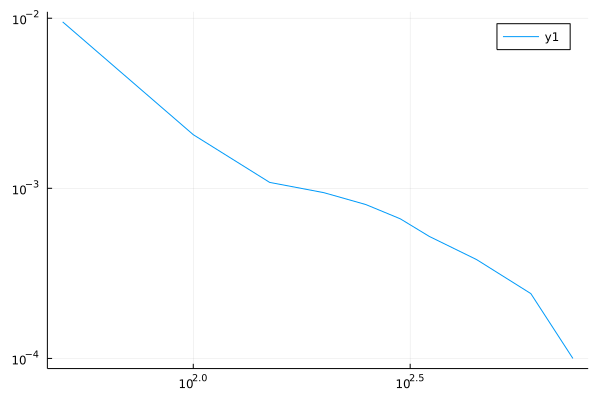

In [149]:
plot(x,1.0001 .- y,yscale=:log10,xscale=:log10)

In [129]:
x = collect(1:1000)
a = autocor(w,collect(1:1000))
b = autocor(s,collect(1:1000))


1000-element Vector{Float64}:
  0.06890939850793072
 -0.04840774559746986
 -0.0432092724996289
  0.12047270542075324
 -0.01735492700253685
 -0.015244996656987206
 -0.03449589476538179
  0.04713433952347225
 -0.02662549307793967
 -0.0011950831942423572
 -0.030278502983547093
  0.04966573657315228
 -0.007796146950764297
  ⋮
  0.003917089489729203
  0.0046195766351575405
 -0.023056399954025874
 -0.00717996021920528
  0.005603041583339479
 -0.007744427372521394
 -0.023618440836621856
 -0.009427995833955849
 -0.013221494640940084
  0.009677475554532803
  0.0064459749916002534
  0.008834456869183162

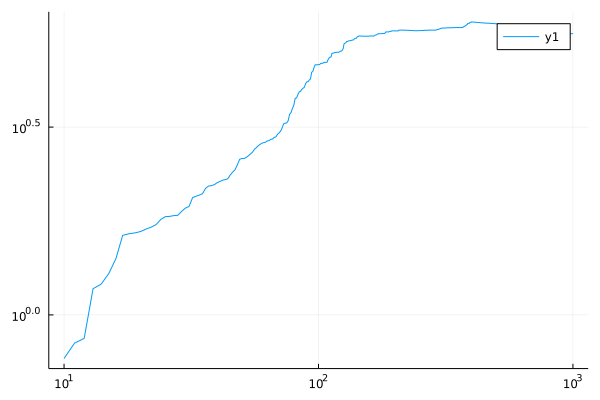

In [135]:
plot(x[10:end],cumsum(a)[10:end],yscale=:log10,xscale=:log10)


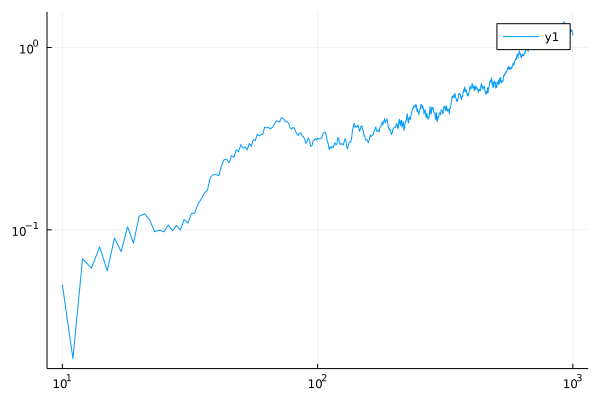

In [134]:
plot(x[10:end],cumsum(b)[10:end],yscale=:log10,xscale=:log10)
